Generating synthetic heart rate data...

ADF Statistic: -0.6668
p-value: 0.8552
=> Series is likely non-stationary.


/var/folders/9t/vr8b9dm17zb3hf6bwsh9_cnc0000gn/T/ipykernel_19699/2110319628.py:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df_resampled.fillna(method=fillna_method)


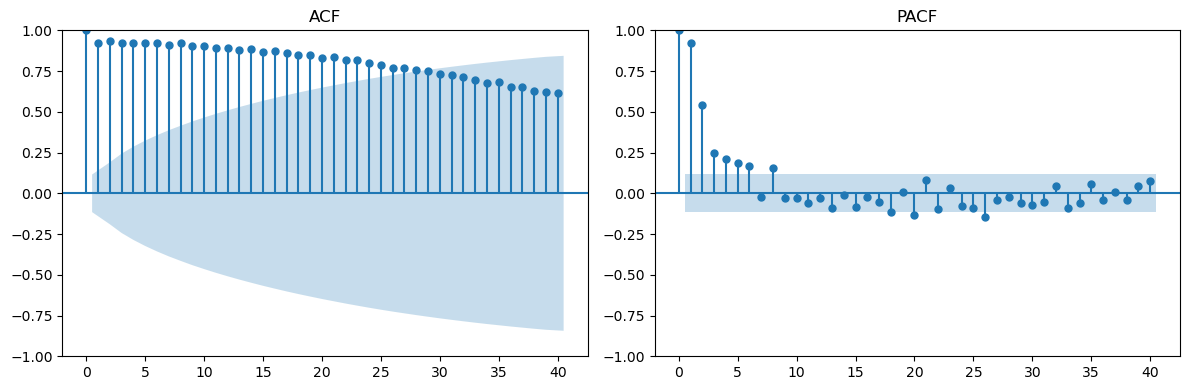

/opt/anaconda3/envs/notebook/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/notebook/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/notebook/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 1.19


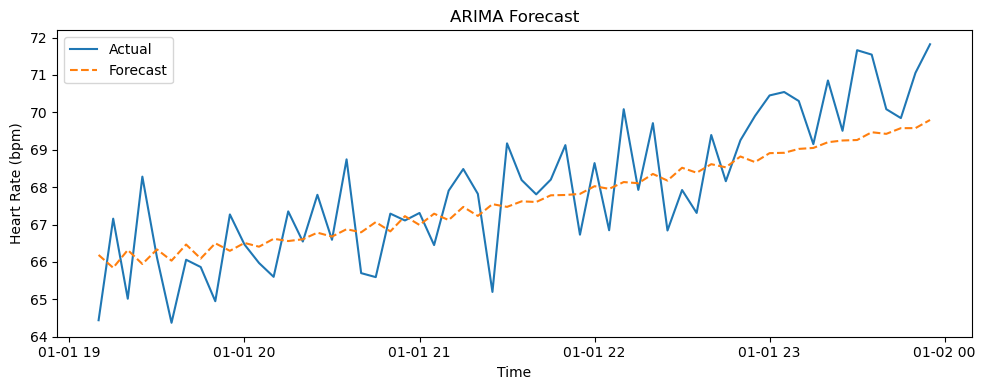

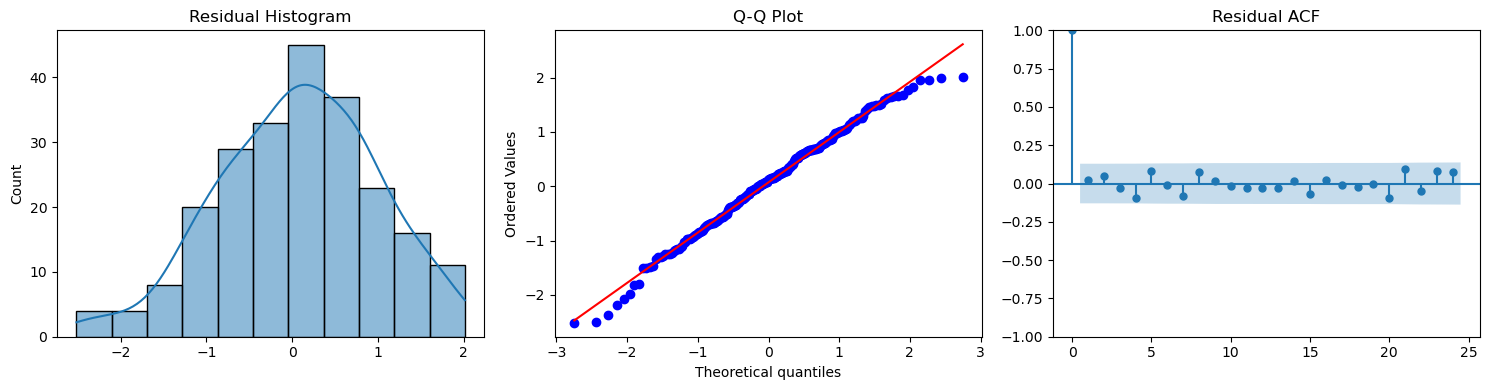

In [3]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import scipy.stats as stats


# 1. Generate Synthetic HR Data


def generate_synthetic_hr(duration_mins=1440, base_hr=70, noise_std=2, trend_slope=0.0005):
    np.random.seed(42)
    timestamps = pd.date_range(start='2024-01-01', periods=duration_mins, freq='min')
    trend = trend_slope * np.arange(duration_mins)
    circadian = 5 * np.sin(np.linspace(0, 2 * np.pi, duration_mins))
    noise = np.random.normal(0, noise_std, duration_mins)
    hr_values = base_hr + trend + circadian + noise
    hr_values = pd.Series(hr_values).clip(lower=50, upper=100).values
    df = pd.DataFrame({'timestamp': timestamps, 'heart_rate': hr_values})
    return df


# 2. Save & Load Data


def save_hr_data(df, path):
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)

def load_hr_data(filepath):
    df = pd.read_csv(filepath, parse_dates=['timestamp'])
    df.set_index('timestamp', inplace=True)
    return df


# 3. Preprocessing


def preprocess_hr(df: pd.DataFrame, resample_rule="5min", fillna_method="ffill"):
    df_resampled = df.resample(resample_rule).mean()
    df_clean = df_resampled.fillna(method=fillna_method)
    return df_clean

def adf_test(series):
    result = adfuller(series.dropna())
    print(f"\nADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] > 0.05:
        print("=> Series is likely non-stationary.")
    else:
        print("=> Series is likely stationary.")

def plot_acf_pacf(series, lags=40):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(series.dropna(), ax=ax[0], lags=lags)
    plot_pacf(series.dropna(), ax=ax[1], lags=lags)
    ax[0].set_title("ACF")
    ax[1].set_title("PACF")
    plt.tight_layout()
    plt.show()


# 4. Modeling


def train_arima_model(series: pd.Series, order=(2,0,2)):
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    return model_fit

def forecast_arima(model_fit, steps=30):
    forecast = model_fit.forecast(steps=steps)
    return forecast


# 5. Diagnostics & Evaluation


def plot_forecast(actual, predicted, title="ARIMA Forecast"):
    plt.figure(figsize=(10, 4))
    plt.plot(actual.index, actual, label="Actual")
    plt.plot(actual.index, predicted, label="Forecast", linestyle="--")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Heart Rate (bpm)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def evaluate_forecast(actual, predicted):
    rmse = mean_squared_error(actual, predicted, squared=False)
    print(f"RMSE: {rmse:.2f}")
    return rmse

def plot_residual_diagnostics(model_fit):
    residuals = model_fit.resid.dropna()
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    sns.histplot(residuals, kde=True, ax=ax[0])
    ax[0].set_title("Residual Histogram")
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Q-Q Plot")
    plot_acf(residuals, ax=ax[2])
    ax[2].set_title("Residual ACF")
    plt.tight_layout()
    plt.show()


# 6. Main Execution


if __name__ == "__main__":
    print("Generating synthetic heart rate data...")

    # Generate & Save
    df_raw = generate_synthetic_hr()
    data_path = Path("data/synthetic_hr.csv")
    save_hr_data(df_raw, data_path)

    # Load
    df = load_hr_data(data_path)

    # Preprocess (resample & fill NA)
    df_clean = preprocess_hr(df, resample_rule="5min")
    
    # Stationarity test & plots on preprocessed data
    adf_test(df_clean["heart_rate"])
    plot_acf_pacf(df_clean["heart_rate"])

    # Train/Test Split on preprocessed data
    split_point = int(len(df_clean) * 0.8)
    train = df_clean.iloc[:split_point]
    test = df_clean.iloc[split_point:]

    # Train ARIMA model on train set
    model = train_arima_model(train["heart_rate"], order=(6,0,6))

    # Forecast length equals test set length
    forecast = forecast_arima(model, steps=len(test))

    # Evaluate forecast
    evaluate_forecast(test["heart_rate"], forecast)

    # Plot forecast vs actual
    plot_forecast(test["heart_rate"], forecast)

    # Plot residual diagnostics
    plot_residual_diagnostics(model)